In [6]:
import os
os.chdir("/home/jupyter/Natasha2")# for GCP use
#os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from numpy import *
import inspect
import time
import torch
from torch import nn, optim
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Lambda
from torch.utils.data import DataLoader
from Natasha1 import Natasha1
from Natasha2 import Natasha2
from Natasha2_hess_prod import Natasha2_hp
from utils import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"]='4,5'

# MNIST

In [7]:
from train import train_val

learning curves have the following information:  
train_loss  
validation_loss  
precision  
recall  
F1  
accuracy  

## LeNet

In [9]:
learning_curves_Natasha1_LeNet = train_val(algorithm='Natasha1', cuda=0, epochs=30, train_portion=0.1, net='MnistLeNet', dataset='MNIST')

[train.py] Using CPU...
[train.py] using optimization algorithm Natasha1
[train.pu] training with 10% of data



Epoch 1/30, training loss: 0.2108268536992673, validation loss: 2.3082499504089355
	     precision: 0.0170
	        recall: 0.0938
	            F1: 0.0239
	      accuracy: 0.0950



Epoch 2/30, training loss: 0.198351577400907, validation loss: 2.2044825553894043
	     precision: 0.1111
	        recall: 0.2084
	            F1: 0.1281
	      accuracy: 0.2071



Epoch 3/30, training loss: 0.19476575866691084, validation loss: 1.9115138053894043
	     precision: 0.1880
	        recall: 0.2882
	            F1: 0.1882
	      accuracy: 0.2853



Epoch 4/30, training loss: 0.14577984365064706, validation loss: 1.4797930717468262
	     precision: 0.4357
	        recall: 0.4857
	            F1: 0.4324
	      accuracy: 0.4858



Epoch 5/30, training loss: 0.1426155779407477, validation loss: 1.3039828538894653
	     precision: 0.5134
	        recall: 0.5146
	            F1: 0.4726
	      accuracy: 0.5235



Epoch 6/30, training loss: 0.14546895116122802, validation loss: 1.1550053358078003
	     precision: 0.5749
	        recall: 0.5946
	            F1: 0.5543
	      accuracy: 0.6064



Epoch 7/30, training loss: 0.12830074223628177, validation loss: 1.1253715753555298
	     precision: 0.5604
	        recall: 0.5861
	            F1: 0.5415
	      accuracy: 0.5974



Epoch 8/30, training loss: 0.09948581101289436, validation loss: 1.0679558515548706
	     precision: 0.5787
	        recall: 0.5965
	            F1: 0.5533
	      accuracy: 0.6104



Epoch 9/30, training loss: 0.11545307003358789, validation loss: 0.9973543286323547
	     precision: 0.6134
	        recall: 0.6137
	            F1: 0.5719
	      accuracy: 0.6265



Epoch 10/30, training loss: 0.11533078119190517, validation loss: 0.9964811205863953
	     precision: 0.6069
	        recall: 0.6000
	            F1: 0.5528
	      accuracy: 0.6142



Epoch 11/30, training loss: 0.11932590800816062, validation loss: 0.9749319553375244
	     precision: 0.6366
	        recall: 0.6295
	            F1: 0.5901
	      accuracy: 0.6358



Epoch 12/30, training loss: 0.0947819361681623, validation loss: 0.8559178709983826
	     precision: 0.7171
	        recall: 0.7009
	            F1: 0.6801
	      accuracy: 0.7127



Epoch 13/30, training loss: 0.09555664321761141, validation loss: 0.7144529819488525
	     precision: 0.7800
	        recall: 0.7650
	            F1: 0.7491
	      accuracy: 0.7709



Epoch 14/30, training loss: 0.072323695555933, validation loss: 0.7364911437034607
	     precision: 0.7710
	        recall: 0.7567
	            F1: 0.7364
	      accuracy: 0.7605



Epoch 15/30, training loss: 0.08353896524860406, validation loss: 0.690146267414093
	     precision: 0.7803
	        recall: 0.7534
	            F1: 0.7365
	      accuracy: 0.7627



Epoch 16/30, training loss: 0.06715723738741519, validation loss: 0.7055702209472656
	     precision: 0.7710
	        recall: 0.7586
	            F1: 0.7365
	      accuracy: 0.7643



Epoch 17/30, training loss: 0.06573403231116501, validation loss: 0.618318498134613
	     precision: 0.8074
	        recall: 0.7931
	            F1: 0.7786
	      accuracy: 0.7998



Epoch 18/30, training loss: 0.06147200641220312, validation loss: 0.5885217785835266
	     precision: 0.8176
	        recall: 0.8063
	            F1: 0.7930
	      accuracy: 0.8121



Epoch 19/30, training loss: 0.06288959206675669, validation loss: 0.5932283401489258
	     precision: 0.8147
	        recall: 0.8080
	            F1: 0.7917
	      accuracy: 0.8141



Epoch 20/30, training loss: 0.0684601635948173, validation loss: 0.5535410642623901
	     precision: 0.8306
	        recall: 0.8181
	            F1: 0.8062
	      accuracy: 0.8247



Epoch 21/30, training loss: 0.05533147109215702, validation loss: 0.5544605851173401
	     precision: 0.8272
	        recall: 0.8190
	            F1: 0.8056
	      accuracy: 0.8241



Epoch 22/30, training loss: 0.06444850230394904, validation loss: 0.5705954432487488
	     precision: 0.8258
	        recall: 0.8114
	            F1: 0.7973
	      accuracy: 0.8163



Epoch 23/30, training loss: 0.059339925551465326, validation loss: 0.5412559509277344
	     precision: 0.8343
	        recall: 0.8250
	            F1: 0.8113
	      accuracy: 0.8290



Epoch 24/30, training loss: 0.04929598444687532, validation loss: 0.5873681902885437
	     precision: 0.8277
	        recall: 0.8033
	            F1: 0.7895
	      accuracy: 0.8100



Epoch 25/30, training loss: 0.05710720142194711, validation loss: 0.5107920169830322
	     precision: 0.8410
	        recall: 0.8347
	            F1: 0.8216
	      accuracy: 0.8390



Epoch 26/30, training loss: 0.05139509502695059, validation loss: 0.5031766295433044
	     precision: 0.8538
	        recall: 0.8475
	            F1: 0.8359
	      accuracy: 0.8509



Epoch 27/30, training loss: 0.055503966965909195, validation loss: 0.4850820004940033
	     precision: 0.8577
	        recall: 0.8526
	            F1: 0.8411
	      accuracy: 0.8558



Epoch 28/30, training loss: 0.05468440452999652, validation loss: 0.4693334400653839
	     precision: 0.8577
	        recall: 0.8530
	            F1: 0.8415
	      accuracy: 0.8570



Epoch 29/30, training loss: 0.05334119028501165, validation loss: 0.4673563838005066
	     precision: 0.8559
	        recall: 0.8499
	            F1: 0.8381
	      accuracy: 0.8550



Epoch 30/30, training loss: 0.04688497162513387, validation loss: 0.47541409730911255
	     precision: 0.8548
	        recall: 0.8481
	            F1: 0.8362
	      accuracy: 0.8529
Training time: 286.2235791683197s


In [ ]:
ax = plt.axes()
ax.set_title("Natasha1")
ax.plot(learning_curves_Natasha1_LeNet['train_loss'], label='training loss')
ax.plot(learning_curves_Natasha1_LeNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [10]:
learning_curves_Adam_LeNet = train_val(algorithm='Adam', cuda=0, epochs=30, train_portion=0.1, net='MnistLeNet', dataset='MNIST')

[train.py] Using CPU...
[train.py] using optimization algorithm Adam
[train.pu] training with 10% of data



Epoch 1/30, training loss: 0.25384918941871953, validation loss: 2.2827563285827637
	     precision: 0.0104
	        recall: 0.1001
	            F1: 0.0186
	      accuracy: 0.1033



Epoch 2/30, training loss: 0.20853993849459487, validation loss: 1.9481614828109741
	     precision: 0.1342
	        recall: 0.3032
	            F1: 0.1768
	      accuracy: 0.3054



Epoch 3/30, training loss: 0.16390978819780003, validation loss: 1.7616333961486816
	     precision: 0.1472
	        recall: 0.3419
	            F1: 0.1988
	      accuracy: 0.3435



Epoch 4/30, training loss: 0.17937107660622995, validation loss: 1.6369996070861816
	     precision: 0.1741
	        recall: 0.3549
	            F1: 0.2189
	      accuracy: 0.3560



Epoch 5/30, training loss: 0.14029923659652027, validation loss: 1.58368718624115
	     precision: 0.2022
	        recall: 0.3599
	            F1: 0.2332
	      accuracy: 0.3619



Epoch 6/30, training loss: 0.19818635370685603, validation loss: 1.5181623697280884
	     precision: 0.2599
	        recall: 0.4109
	            F1: 0.2943
	      accuracy: 0.4198



Epoch 7/30, training loss: 0.15015719325811877, validation loss: 1.4832351207733154
	     precision: 0.2637
	        recall: 0.3978
	            F1: 0.2842
	      accuracy: 0.4042



Epoch 8/30, training loss: 0.13767347152807566, validation loss: 1.470772624015808
	     precision: 0.3173
	        recall: 0.4364
	            F1: 0.3302
	      accuracy: 0.4481



Epoch 9/30, training loss: 0.1306895176484895, validation loss: 1.4323166608810425
	     precision: 0.3444
	        recall: 0.4526
	            F1: 0.3548
	      accuracy: 0.4656



Epoch 10/30, training loss: 0.15211392033583065, validation loss: 1.3983166217803955
	     precision: 0.3557
	        recall: 0.4626
	            F1: 0.3649
	      accuracy: 0.4773



Epoch 11/30, training loss: 0.12413983520414275, validation loss: 1.3808848857879639
	     precision: 0.4137
	        recall: 0.4870
	            F1: 0.4017
	      accuracy: 0.4981



Epoch 12/30, training loss: 0.12847941732609958, validation loss: 1.3456048965454102
	     precision: 0.4108
	        recall: 0.4862
	            F1: 0.3958
	      accuracy: 0.4987



Epoch 13/30, training loss: 0.11650298539001042, validation loss: 1.3204864263534546
	     precision: 0.4344
	        recall: 0.5002
	            F1: 0.4151
	      accuracy: 0.5140



Epoch 14/30, training loss: 0.1396906741265295, validation loss: 1.2882241010665894
	     precision: 0.4621
	        recall: 0.5154
	            F1: 0.4366
	      accuracy: 0.5280



Epoch 15/30, training loss: 0.1348288207928509, validation loss: 1.2706722021102905
	     precision: 0.4600
	        recall: 0.5140
	            F1: 0.4332
	      accuracy: 0.5269



Epoch 16/30, training loss: 0.12693749365013546, validation loss: 1.2553390264511108
	     precision: 0.4703
	        recall: 0.5209
	            F1: 0.4480
	      accuracy: 0.5346



Epoch 17/30, training loss: 0.11683840468239937, validation loss: 1.226793646812439
	     precision: 0.4870
	        recall: 0.5342
	            F1: 0.4624
	      accuracy: 0.5469



Epoch 18/30, training loss: 0.1276068632155339, validation loss: 1.2117528915405273
	     precision: 0.4856
	        recall: 0.5358
	            F1: 0.4631
	      accuracy: 0.5477



Epoch 19/30, training loss: 0.10901166311205068, validation loss: 1.205332636833191
	     precision: 0.5013
	        recall: 0.5455
	            F1: 0.4743
	      accuracy: 0.5567



Epoch 20/30, training loss: 0.12020833443985311, validation loss: 1.1784824132919312
	     precision: 0.5098
	        recall: 0.5563
	            F1: 0.4912
	      accuracy: 0.5676



Epoch 21/30, training loss: 0.12446061742585351, validation loss: 1.1631085872650146
	     precision: 0.5197
	        recall: 0.5611
	            F1: 0.4965
	      accuracy: 0.5733



Epoch 22/30, training loss: 0.12846227597071927, validation loss: 1.1460230350494385
	     precision: 0.5351
	        recall: 0.5719
	            F1: 0.5116
	      accuracy: 0.5838



Epoch 23/30, training loss: 0.11508535512728986, validation loss: 1.1340652704238892
	     precision: 0.5314
	        recall: 0.5674
	            F1: 0.5071
	      accuracy: 0.5794



Epoch 24/30, training loss: 0.09814078016067619, validation loss: 1.1306302547454834
	     precision: 0.5190
	        recall: 0.5629
	            F1: 0.4983
	      accuracy: 0.5740



Epoch 25/30, training loss: 0.12236522783094378, validation loss: 1.1173208951950073
	     precision: 0.5440
	        recall: 0.5829
	            F1: 0.5262
	      accuracy: 0.5947



Epoch 26/30, training loss: 0.1154434770536321, validation loss: 1.1028287410736084
	     precision: 0.5534
	        recall: 0.5841
	            F1: 0.5278
	      accuracy: 0.5969



Epoch 27/30, training loss: 0.09989095484015784, validation loss: 1.095366358757019
	     precision: 0.5860
	        recall: 0.5985
	            F1: 0.5555
	      accuracy: 0.6101



Epoch 28/30, training loss: 0.10250159049593309, validation loss: 1.083343505859375
	     precision: 0.5658
	        recall: 0.5966
	            F1: 0.5469
	      accuracy: 0.6088



Epoch 29/30, training loss: 0.10696946894690426, validation loss: 1.0732530355453491
	     precision: 0.5597
	        recall: 0.6017
	            F1: 0.5483
	      accuracy: 0.6140



Epoch 30/30, training loss: 0.10974731297889498, validation loss: 1.0634632110595703
	     precision: 0.5644
	        recall: 0.6079
	            F1: 0.5531
	      accuracy: 0.6205
Training time: 257.9153034687042s


In [ ]:
ax = plt.axes()
ax.set_title("Adam")
ax.plot(learning_curves_Adam_LeNet['train_loss'], label='training loss')
ax.plot(learning_curves_Adam_LeNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [11]:
learning_curves_SGD_LeNet = train_val(algorithm='SGD', cuda=0, epochs=30, train_portion=0.1, net='MnistLeNet', dataset='MNIST')

[train.py] Using CPU...
[train.py] using optimization algorithm SGD
[train.pu] training with 10% of data



Epoch 1/30, training loss: 0.2302362153779215, validation loss: 2.3202905654907227
	     precision: 0.0101
	        recall: 0.1001
	            F1: 0.0182
	      accuracy: 0.1011



Epoch 2/30, training loss: 0.1951487491379923, validation loss: 2.3134970664978027
	     precision: 0.0101
	        recall: 0.1001
	            F1: 0.0182
	      accuracy: 0.1011



Epoch 3/30, training loss: 0.24103986810265318, validation loss: 2.3051393032073975
	     precision: 0.0101
	        recall: 0.1001
	            F1: 0.0183
	      accuracy: 0.1011



Epoch 4/30, training loss: 0.2010990820968075, validation loss: 2.296281337738037
	     precision: 0.0200
	        recall: 0.1039
	            F1: 0.0237
	      accuracy: 0.1050



Epoch 5/30, training loss: 0.21742822824002328, validation loss: 2.284066915512085
	     precision: 0.0481
	        recall: 0.1222
	            F1: 0.0439
	      accuracy: 0.1236



Epoch 6/30, training loss: 0.21605758346728424, validation loss: 2.263887882232666
	     precision: 0.0804
	        recall: 0.1912
	            F1: 0.0977
	      accuracy: 0.1935



Epoch 7/30, training loss: 0.215680753752621, validation loss: 2.224884271621704
	     precision: 0.0821
	        recall: 0.2121
	            F1: 0.1092
	      accuracy: 0.2157



Epoch 8/30, training loss: 0.23128892973796136, validation loss: 2.136420726776123
	     precision: 0.1350
	        recall: 0.2423
	            F1: 0.1516
	      accuracy: 0.2442



Epoch 9/30, training loss: 0.2153758017747387, validation loss: 1.967226266860962
	     precision: 0.1680
	        recall: 0.3234
	            F1: 0.2119
	      accuracy: 0.3230



Epoch 10/30, training loss: 0.18078171825612277, validation loss: 1.798560619354248
	     precision: 0.2236
	        recall: 0.3456
	            F1: 0.2458
	      accuracy: 0.3454



Epoch 11/30, training loss: 0.15389885907488338, validation loss: 1.6776840686798096
	     precision: 0.2503
	        recall: 0.3579
	            F1: 0.2536
	      accuracy: 0.3581



Epoch 12/30, training loss: 0.12621292236771411, validation loss: 1.5753213167190552
	     precision: 0.3310
	        recall: 0.4624
	            F1: 0.3472
	      accuracy: 0.4741



Epoch 13/30, training loss: 0.16633993514311085, validation loss: 1.4640790224075317
	     precision: 0.3444
	        recall: 0.4801
	            F1: 0.3670
	      accuracy: 0.4929



Epoch 14/30, training loss: 0.15893902516822572, validation loss: 1.338321328163147
	     precision: 0.4430
	        recall: 0.5180
	            F1: 0.4267
	      accuracy: 0.5312



Epoch 15/30, training loss: 0.12489703456476045, validation loss: 1.2457462549209595
	     precision: 0.4828
	        recall: 0.5446
	            F1: 0.4600
	      accuracy: 0.5570



Epoch 16/30, training loss: 0.12676642431633306, validation loss: 1.2018202543258667
	     precision: 0.5447
	        recall: 0.5631
	            F1: 0.5006
	      accuracy: 0.5753



Epoch 17/30, training loss: 0.13435989243389446, validation loss: 1.1698057651519775
	     precision: 0.5677
	        recall: 0.5809
	            F1: 0.5226
	      accuracy: 0.5915



Epoch 18/30, training loss: 0.10083768775722365, validation loss: 1.1273753643035889
	     precision: 0.5959
	        recall: 0.6000
	            F1: 0.5577
	      accuracy: 0.6128



Epoch 19/30, training loss: 0.12616660098022997, validation loss: 1.0736786127090454
	     precision: 0.6082
	        recall: 0.6151
	            F1: 0.5616
	      accuracy: 0.6263



Epoch 20/30, training loss: 0.09717392730814561, validation loss: 1.0458002090454102
	     precision: 0.6235
	        recall: 0.6267
	            F1: 0.5824
	      accuracy: 0.6398



Epoch 21/30, training loss: 0.12735660580683872, validation loss: 1.0393402576446533
	     precision: 0.6461
	        recall: 0.6416
	            F1: 0.5999
	      accuracy: 0.6523



Epoch 22/30, training loss: 0.10068040349081889, validation loss: 1.0167009830474854
	     precision: 0.6809
	        recall: 0.6626
	            F1: 0.6351
	      accuracy: 0.6731



Epoch 23/30, training loss: 0.10189026791149619, validation loss: 1.0064446926116943
	     precision: 0.6762
	        recall: 0.6669
	            F1: 0.6379
	      accuracy: 0.6750



Epoch 24/30, training loss: 0.11793176985498685, validation loss: 1.0133501291275024
	     precision: 0.6520
	        recall: 0.6475
	            F1: 0.6069
	      accuracy: 0.6571



Epoch 25/30, training loss: 0.10148164134289918, validation loss: 0.9775989055633545
	     precision: 0.6939
	        recall: 0.6715
	            F1: 0.6446
	      accuracy: 0.6815



Epoch 26/30, training loss: 0.08473883146670327, validation loss: 0.9618076682090759
	     precision: 0.6847
	        recall: 0.6810
	            F1: 0.6503
	      accuracy: 0.6897



Epoch 27/30, training loss: 0.103315778442029, validation loss: 0.9405566453933716
	     precision: 0.6930
	        recall: 0.6810
	            F1: 0.6512
	      accuracy: 0.6914



Epoch 28/30, training loss: 0.09276214934615439, validation loss: 0.9585291147232056
	     precision: 0.6813
	        recall: 0.6625
	            F1: 0.6325
	      accuracy: 0.6753



Epoch 29/30, training loss: 0.0972078253211243, validation loss: 0.9707814455032349
	     precision: 0.6722
	        recall: 0.6680
	            F1: 0.6313
	      accuracy: 0.6763



Epoch 30/30, training loss: 0.08671595121243361, validation loss: 0.9117156863212585
	     precision: 0.7182
	        recall: 0.6964
	            F1: 0.6775
	      accuracy: 0.7055
Training time: 254.07726454734802s


In [ ]:
ax = plt.axes()
ax.set_title("SGD")
ax.plot(learning_curves_SGD_LeNet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_LeNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [12]:
learning_curves_SGD_momentum_LeNet = train_val(algorithm='SGD_momentum', cuda=0, epochs=30, train_portion=0.1, net='MnistLeNet', dataset='MNIST')

[train.py] Using CPU...
[train.py] using optimization algorithm SGD_momentum
[train.pu] training with 10% of data



Epoch 1/30, training loss: 0.2579116466711325, validation loss: 1.9420921802520752
	     precision: 0.3692
	        recall: 0.4020
	            F1: 0.3286
	      accuracy: 0.4133



Epoch 2/30, training loss: 0.11885916367014333, validation loss: 0.8313257694244385
	     precision: 0.7306
	        recall: 0.7285
	            F1: 0.7000
	      accuracy: 0.7347



Epoch 3/30, training loss: 0.07337539301498104, validation loss: 0.6380129456520081
	     precision: 0.8000
	        recall: 0.7965
	            F1: 0.7808
	      accuracy: 0.8001



Epoch 4/30, training loss: 0.05877942622089183, validation loss: 0.5722653269767761
	     precision: 0.8276
	        recall: 0.8176
	            F1: 0.8006
	      accuracy: 0.8213



Epoch 5/30, training loss: 0.05093930054829319, validation loss: 0.46139127016067505
	     precision: 0.8690
	        recall: 0.8614
	            F1: 0.8509
	      accuracy: 0.8639



Epoch 6/30, training loss: 0.04896863783473399, validation loss: 0.5010786652565002
	     precision: 0.8434
	        recall: 0.8244
	            F1: 0.8100
	      accuracy: 0.8281



Epoch 7/30, training loss: 0.04810620590186577, validation loss: 0.34783241152763367
	     precision: 0.9014
	        recall: 0.8962
	            F1: 0.8877
	      accuracy: 0.8985



Epoch 8/30, training loss: 0.03949966516766721, validation loss: 0.3270524740219116
	     precision: 0.9035
	        recall: 0.8965
	            F1: 0.8895
	      accuracy: 0.9011



Epoch 9/30, training loss: 0.03093067801265574, validation loss: 0.3086591958999634
	     precision: 0.9070
	        recall: 0.9022
	            F1: 0.8947
	      accuracy: 0.9051



Epoch 10/30, training loss: 0.029714832205508055, validation loss: 0.294344961643219
	     precision: 0.9134
	        recall: 0.9073
	            F1: 0.9000
	      accuracy: 0.9098



Epoch 11/30, training loss: 0.03165298789294798, validation loss: 0.29143452644348145
	     precision: 0.9174
	        recall: 0.9143
	            F1: 0.9063
	      accuracy: 0.9155



Epoch 12/30, training loss: 0.028198754395058416, validation loss: 0.2700634002685547
	     precision: 0.9224
	        recall: 0.9187
	            F1: 0.9115
	      accuracy: 0.9206



Epoch 13/30, training loss: 0.02229982041029025, validation loss: 0.2798796594142914
	     precision: 0.9229
	        recall: 0.9191
	            F1: 0.9123
	      accuracy: 0.9203



Epoch 14/30, training loss: 0.028038026999308865, validation loss: 0.29290854930877686
	     precision: 0.9194
	        recall: 0.9113
	            F1: 0.9051
	      accuracy: 0.9147



Epoch 15/30, training loss: 0.028910733648200532, validation loss: 0.2734076976776123
	     precision: 0.9209
	        recall: 0.9134
	            F1: 0.9068
	      accuracy: 0.9156



Epoch 16/30, training loss: 0.031009302043647907, validation loss: 0.24676433205604553
	     precision: 0.9265
	        recall: 0.9219
	            F1: 0.9163
	      accuracy: 0.9251



Epoch 17/30, training loss: 0.025272721944968584, validation loss: 0.23639467358589172
	     precision: 0.9329
	        recall: 0.9316
	            F1: 0.9249
	      accuracy: 0.9322



Epoch 18/30, training loss: 0.022795450156812728, validation loss: 0.32015690207481384
	     precision: 0.9081
	        recall: 0.8994
	            F1: 0.8905
	      accuracy: 0.9024



Epoch 19/30, training loss: 0.02744770047665913, validation loss: 0.22631347179412842
	     precision: 0.9353
	        recall: 0.9333
	            F1: 0.9275
	      accuracy: 0.9344



Epoch 20/30, training loss: 0.022312087560894648, validation loss: 0.24104294180870056
	     precision: 0.9325
	        recall: 0.9297
	            F1: 0.9238
	      accuracy: 0.9309



Epoch 21/30, training loss: 0.027300843107166576, validation loss: 0.23994041979312897
	     precision: 0.9316
	        recall: 0.9263
	            F1: 0.9210
	      accuracy: 0.9281



Epoch 22/30, training loss: 0.03208940891600621, validation loss: 0.22993288934230804
	     precision: 0.9325
	        recall: 0.9307
	            F1: 0.9240
	      accuracy: 0.9322



Epoch 23/30, training loss: 0.02541247861328791, validation loss: 0.22931142151355743
	     precision: 0.9344
	        recall: 0.9312
	            F1: 0.9260
	      accuracy: 0.9329



Epoch 24/30, training loss: 0.02413280487759535, validation loss: 0.2222621738910675
	     precision: 0.9362
	        recall: 0.9325
	            F1: 0.9275
	      accuracy: 0.9342



Epoch 25/30, training loss: 0.022139230786737348, validation loss: 0.21931488811969757
	     precision: 0.9351
	        recall: 0.9311
	            F1: 0.9253
	      accuracy: 0.9326



Epoch 26/30, training loss: 0.02426960808969637, validation loss: 0.20643797516822815
	     precision: 0.9417
	        recall: 0.9393
	            F1: 0.9347
	      accuracy: 0.9412



Epoch 27/30, training loss: 0.026193758858038166, validation loss: 0.2273457944393158
	     precision: 0.9373
	        recall: 0.9325
	            F1: 0.9276
	      accuracy: 0.9344



Epoch 28/30, training loss: 0.02290964090446038, validation loss: 0.2162531465291977
	     precision: 0.9394
	        recall: 0.9373
	            F1: 0.9322
	      accuracy: 0.9389



Epoch 29/30, training loss: 0.021452783489786485, validation loss: 0.22367508709430695
	     precision: 0.9354
	        recall: 0.9318
	            F1: 0.9268
	      accuracy: 0.9340



Epoch 30/30, training loss: 0.02381426721874839, validation loss: 0.215542733669281
	     precision: 0.9410
	        recall: 0.9379
	            F1: 0.9327
	      accuracy: 0.9395
Training time: 258.3604688644409s


In [ ]:
ax = plt.axes()
ax.set_title("SGD momentum")
ax.plot(learning_curves_SGD_momentum_LeNet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_momentum_LeNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [3]:
learning_curves_Natasha2_hp_LeNet = train_val(algorithm='Natasha2_hp', cuda=0, epochs=30, train_portion=0.1, net='MnistLeNet', dataset='MNIST')

[train.py] Using CPU...
[train.py] using optimization algorithm Natasha2_hp
[train.pu] training with 10% of data


kick
kick
kick
kick
kick
kick
kick
kick
kick

Epoch 1/30, training loss: 0.2029199246912877, validation loss: 2.3148019313812256
	     precision: 0.0388
	        recall: 0.1548
	            F1: 0.0582
	      accuracy: 0.1711


kick
kick
kick
kick
kick
kick
kick
kick
kick
kick
kick
kick
kick

Epoch 2/30, training loss: 0.17533759038839766, validation loss: 2.3162715435028076
	     precision: 0.0114
	        recall: 0.1001
	            F1: 0.0202
	      accuracy: 0.1136


kick
kick
kick
kick
kick
kick
kick
kick

Epoch 3/30, training loss: 0.22415081117707275, validation loss: 2.310134172439575
	     precision: 0.0114
	        recall: 0.1001
	            F1: 0.0202
	      accuracy: 0.1136


kick
kick
kick
kick

Epoch 4/30, training loss: 0.22379422772413632, validation loss: 2.3051645755767822
	     precision: 0.0114
	        recall: 0.1001
	            F1: 0.0202
	      accuracy: 0.1136


kick
kick
kick
kick
kick
kick
kick

Epoch 5/30, training loss: 0.21617279835601352, validation loss: 2.3020572662353516
	     precision: 0.0114
	        recall: 0.1001
	            F1: 0.0202
	      accuracy: 0.1136


kick
kick
kick

Epoch 6/30, training loss: 0.19616329314103767, validation loss: 2.299180746078491
	     precision: 0.0114
	        recall: 0.1001
	            F1: 0.0202
	      accuracy: 0.1136


kick
kick
kick
kick
kick
kick

Epoch 7/30, training loss: 0.18117381413099862, validation loss: 2.2988593578338623
	     precision: 0.0114
	        recall: 0.1001
	            F1: 0.0202
	      accuracy: 0.1136


kick
kick
kick
kick
kick

Epoch 8/30, training loss: 0.2301943574124562, validation loss: 2.296328067779541
	     precision: 0.0114
	        recall: 0.1001
	            F1: 0.0202
	      accuracy: 0.1136


kick
kick
kick
kick
kick

Epoch 9/30, training loss: 0.22989854960045072, validation loss: 2.2930850982666016
	     precision: 0.0114
	        recall: 0.1001
	            F1: 0.0202
	      accuracy: 0.1136


kick
kick
kick
kick
kick
kick
kick
kick

Epoch 10/30, training loss: 0.21265819026971422, validation loss: 2.292041063308716
	     precision: 0.0114
	        recall: 0.1001
	            F1: 0.0202
	      accuracy: 0.1136


kick
kick
kick
kick
kick
kick
kick
kick
kick
kick

Epoch 11/30, training loss: 0.24396927931161325, validation loss: 2.2882823944091797
	     precision: 0.0306
	        recall: 0.1070
	            F1: 0.0299
	      accuracy: 0.1201


kick
kick
kick

Epoch 12/30, training loss: 0.19756398297576253, validation loss: 2.2837793827056885
	     precision: 0.0499
	        recall: 0.1355
	            F1: 0.0583
	      accuracy: 0.1490


kick
kick
kick
kick
kick
kick

Epoch 13/30, training loss: 0.2210608868202421, validation loss: 2.2730705738067627
	     precision: 0.1097
	        recall: 0.2023
	            F1: 0.1167
	      accuracy: 0.2153


kick
kick
kick
kick
kick
kick
kick
kick
kick

Epoch 14/30, training loss: 0.2656849660853079, validation loss: 2.252937078475952
	     precision: 0.1083
	        recall: 0.2124
	            F1: 0.1148
	      accuracy: 0.2256


kick
kick
kick
kick
kick
kick

Epoch 15/30, training loss: 0.20681941000891646, validation loss: 2.203447103500366
	     precision: 0.0756
	        recall: 0.1663
	            F1: 0.0916
	      accuracy: 0.1755


kick
kick
kick
kick
kick
kick

Epoch 16/30, training loss: 0.17160418877469452, validation loss: 2.1451117992401123
	     precision: 0.0367
	        recall: 0.1696
	            F1: 0.0593
	      accuracy: 0.1829


kick
kick
kick

Epoch 17/30, training loss: 0.1892801474914876, validation loss: 2.0844643115997314
	     precision: 0.0506
	        recall: 0.1635
	            F1: 0.0705
	      accuracy: 0.1754


kick
kick
kick
kick

Epoch 18/30, training loss: 0.19957977101238553, validation loss: 2.037428855895996
	     precision: 0.0705
	        recall: 0.1800
	            F1: 0.0926
	      accuracy: 0.1926


kick
kick

Epoch 19/30, training loss: 0.17839251715999677, validation loss: 2.003662586212158
	     precision: 0.0731
	        recall: 0.1977
	            F1: 0.0938
	      accuracy: 0.2125


kick
kick

Epoch 20/30, training loss: 0.21241546490553345, validation loss: 1.9755525588989258
	     precision: 0.0637
	        recall: 0.1983
	            F1: 0.0907
	      accuracy: 0.2131



Epoch 21/30, training loss: 0.20965459987298765, validation loss: 1.9531941413879395
	     precision: 0.1127
	        recall: 0.2157
	            F1: 0.1326
	      accuracy: 0.2279


kick

Epoch 22/30, training loss: 0.17426865568547362, validation loss: 1.9431679248809814
	     precision: 0.0723
	        recall: 0.1929
	            F1: 0.0948
	      accuracy: 0.2057


kick

Epoch 23/30, training loss: 0.17227517592627356, validation loss: 1.920354962348938
	     precision: 0.0968
	        recall: 0.2112
	            F1: 0.1099
	      accuracy: 0.2259


kick

Epoch 24/30, training loss: 0.20409364791821316, validation loss: 1.9076695442199707
	     precision: 0.1439
	        recall: 0.2106
	            F1: 0.1400
	      accuracy: 0.2236


kick
kick
kick
kick
kick

Epoch 25/30, training loss: 0.205796681487484, validation loss: 1.8931422233581543
	     precision: 0.1097
	        recall: 0.2135
	            F1: 0.1190
	      accuracy: 0.2274


kick
kick

Epoch 26/30, training loss: 0.20888262796503648, validation loss: 1.885414481163025
	     precision: 0.1330
	        recall: 0.2275
	            F1: 0.1312
	      accuracy: 0.2383



Epoch 27/30, training loss: 0.15904915243832032, validation loss: 1.8737192153930664
	     precision: 0.1274
	        recall: 0.2252
	            F1: 0.1368
	      accuracy: 0.2328


kick

Epoch 28/30, training loss: 0.17010726031464046, validation loss: 1.8632270097732544
	     precision: 0.1386
	        recall: 0.2326
	            F1: 0.1386
	      accuracy: 0.2403


kick
kick
kick
kick
kick
kick

Epoch 29/30, training loss: 0.23527954483845595, validation loss: 1.8859338760375977
	     precision: 0.1065
	        recall: 0.1930
	            F1: 0.1153
	      accuracy: 0.1969


kick

Epoch 30/30, training loss: 0.150682885001209, validation loss: 1.8537347316741943
	     precision: 0.1670
	        recall: 0.2285
	            F1: 0.1624
	      accuracy: 0.2372
Training time: 3080.536412000656s


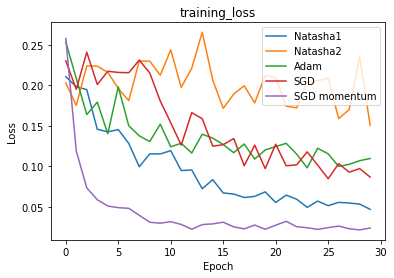

In [15]:
ax = plt.axes()
ax.set_title("training_loss")
ax.plot(learning_curves_Natasha1_LeNet['train_loss'], label='Natasha1')
ax.plot(learning_curves_Natasha2_hp_LeNet['train_loss'], label= 'Natasha2')
ax.plot(learning_curves_Adam_LeNet['train_loss'], label='Adam')
ax.plot(learning_curves_SGD_LeNet['train_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_LeNet['train_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.savefig("MNISTLeNet.png")

In [ ]:
ax = plt.axes()
ax.set_title("validation_loss")
ax.plot(learning_curves_Natasha1_LeNet['validation_loss'], label='Natasha1')
ax.plot(learning_curves_Adam_LeNet['validation_loss'], label='Adam')
ax.plot(learning_curves_SGD_LeNet['validation_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_LeNet['validation_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

## ResNet

In [ ]:
learning_curves_Natasha1_ResNet = train_val(algorithm='Natasha1', cuda=0, epochs=10, train_portion=0.1, net='MnistResNet', dataset='MNIST')

In [ ]:
ax = plt.axes()
ax.set_title("Natasha1")
ax.plot(learning_curves_Natasha1_ResNet['train_loss'], label='training loss')
ax.plot(learning_curves_Natasha1_ResNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
learning_curves_Adam_ResNet = train_val(algorithm='Adam', cuda=0, epochs=10, train_portion=0.1, net='MnistResNet', dataset='MNIST')

In [ ]:
ax = plt.axes()
ax.set_title("Adam")
ax.plot(learning_curves_Adam_ResNet['train_loss'], label='training loss')
ax.plot(learning_curves_Adam_ResNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
learning_curves_SGD_ResNet = train_val(algorithm='SGD', cuda=0, epochs=10, train_portion=0.1, net='MnistResNet', dataset='MNIST')

In [ ]:
ax = plt.axes()
ax.set_title("SGD")
ax.plot(learning_curves_SGD_ResNet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_ResNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
learning_curves_SGD_momentum_ResNet = train_val(algorithm='SGD_momentum', cuda=0, epochs=10, train_portion=0.1, net='MnistResNet', dataset='MNIST')

In [ ]:
ax = plt.axes()
ax.set_title("SGD momentum")
ax.plot(learning_curves_SGD_momentum_ResNet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_momentum_ResNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
ax = plt.axes()
ax.set_title("training_loss")
ax.plot(learning_curves_Natasha1_ResNet['train_loss'], label='Natasha1')
ax.plot(learning_curves_Adam_ResNet['train_loss'], label='Adam')
ax.plot(learning_curves_SGD_ResNet['train_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_ResNet['train_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
ax = plt.axes()
ax.set_title("validation_loss")
ax.plot(learning_curves_Natasha1_ResNet['validation_loss'], label='Natasha1')
ax.plot(learning_curves_Adam_ResNet['validation_loss'], label='Adam')
ax.plot(learning_curves_SGD_ResNet['validation_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_ResNet['validation_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

# Linear model for debugging

In [ ]:
import numpy as np
# create dummy data for training
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

In [ ]:
import torch
from torch.autograd import Variable
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 10

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [ ]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
optimizer = Natasha2(model.parameters(), alpha=learningRate)

In [ ]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward(retain_graph=True)
    
    hessian_matrix = eval_hessian(loss, model)
    # update parameters
    optimizer.step(hessian_matrix)

    print('epoch {}, loss {}'.format(epoch, loss.item()))